In [1]:
# ============================================================================
# CELL 1: Import Libraries
# ============================================================================
import pandas as pd
import numpy as np
import re
import string

# NLP Libraries
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Transformers & PyTorch
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

# Sklearn
from sklearn.metrics.pairwise import cosine_similarity

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")


✅ All libraries imported successfully!
PyTorch version: 2.8.0+cu126
CUDA available: True


In [2]:
# ============================================================================
# CELL 2: Load Data & Save Combined Dataset
# ============================================================================
import pandas as pd

# Load datasets
df1 = pd.read_csv('hellosehat_dataset_10.csv', sep=';', quotechar='"', encoding='utf-8')
df2 = pd.read_csv('alodokter_dataset_10.csv', sep=';', quotechar='"', encoding='utf-8')

# Combine datasets
df_combine = pd.concat([df1, df2], ignore_index=True)

# Save combined dataset
df_combine.to_csv('combined_nutrisi_dataset.csv', sep=';', quotechar='"', 
                  encoding='utf-8', index=False)

print(f"✅ Data loaded successfully!")
print(f"Total articles: {len(df_combine)}")
print(f"Columns: {df_combine.columns.tolist()}")
print(f"✅ Combined dataset saved as 'combined_nutrisi_dataset.csv'")

print(f"\n📊 Dataset Statistics:")
print(f"  - HalloSehat articles: {len(df1)}")
print(f"  - Alodokter articles: {len(df2)}")
print(f"  - Total combined: {len(df_combine)}")

print(f"\n🔍 Sample data:")
print(df_combine.head(2))

# Verify saved file
print(f"\n✅ Verification - Loading saved file:")
df_test = pd.read_csv('combined_nutrisi_dataset.csv', sep=';', quotechar='"', encoding='utf-8')
print(f"  - Rows in saved file: {len(df_test)}")
print(f"  - Columns in saved file: {df_test.columns.tolist()}")

✅ Data loaded successfully!
Total articles: 1539
Columns: ['URL', 'Judul', 'Konten']
✅ Combined dataset saved as 'combined_nutrisi_dataset.csv'

📊 Dataset Statistics:
  - HalloSehat articles: 608
  - Alodokter articles: 931
  - Total combined: 1539

🔍 Sample data:
                                                 URL  \
0  https://hellosehat.com/nutrisi/berat-badan-tur...   
1  https://hellosehat.com/nutrisi/tips-makan-seha...   

                                               Judul  \
0  Kenali 9 Penyebab Perut Buncit dan Cara Mengat...   
1    8 Merk Oven Gas Terbaik, Cocok untuk Bisnis Kue   

                                              Konten  
0  Perut buncit memang mampu memengaruhi penampil...  
1  Bagi Anda yang gemar bikin kue, oven gas menja...  

✅ Verification - Loading saved file:
  - Rows in saved file: 1539
  - Columns in saved file: ['URL', 'Judul', 'Konten']


In [3]:
# Load combined dataset (lebih cepat)
df_combine = pd.read_csv('combined_nutrisi_dataset.csv', sep=';', 
                         quotechar='"', encoding='utf-8')

In [4]:
# ============================================================================
# CELL 3: Text Preprocessor (Light Version for BERT)
# ============================================================================
class LightTextPreprocessor:
    def __init__(self):
        self.stemmer = StemmerFactory().create_stemmer()
        self.stopword_remover = StopWordRemoverFactory().create_stop_word_remover()
        
    def preprocess(self, text):
        """Minimal preprocessing - hanya cleaning dasar"""
        # Lowercase
        text = text.lower()
        
        # Remove URLs
        text = re.sub(r'https?://\S+|www\.\S+', '', text)
        
        # Remove special characters tapi keep spaces
        text = re.sub(r'[^a-zA-Z\s]', ' ', text)
        
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text

preprocessor = LightTextPreprocessor()

✅ Light Text Preprocessor initialized!

Example preprocessing:
Original: Ini adalah contoh text dengan URL https://example.com dan angka 123!
Cleaned:  ini adalah contoh text dengan url dan angka


In [17]:
# ============================================================================
# CELL 4: Health Goals Dictionary (Expanded)
# ============================================================================
HEALTH_GOALS = {
    'menurunkan_berat_badan': {
        'keywords': [
            # Istilah Umum
            'kurus', 'langsing', 'diet', 'turun berat', 'menurunkan berat badan', 
            'berat badan ideal', 'bakar lemak', 'body goals',
            # Masalah Spesifik
            'obesitas', 'gemuk', 'kegemukan', 'perut buncit', 'lemak visceral', 
            'double chin', 'paha besar', 'lengan besar',
            # Metode & Konsep
            'diet defisit kalori', 'intermittent fasting', 'ocd', 'diet keto', 
            'rendah karbo', 'low carb', 'pengganti nasi', 'diet mayo',
            'diet jus', 'jus diet', 'teh diet', 'pelangsing'
        ],
        'related_concepts': [
            'kalori', 'metabolisme', 'bmr', 'tde', 'indeks massa tubuh', 'bmi', 
            'serat', 'kenyang', 'jendela makan', 'defisit'
        ]
    },

    'kesehatan_anak': {
        'keywords': [
            # Fase Anak
            'anak', 'balita', 'bayi', 'batita', 'si kecil', 'buah hati',
            # Masalah Gizi
            'stunting', 'gizi buruk', 'kurang gizi', 'anak gemuk', 'obesitas anak', 
            'susah makan', 'gtm', 'pilih-pilih makanan', 'picky eater',
            # Nutrisi & Pertumbuhan
            'tumbuh kembang', 'tinggi badan', 'penambah berat anak', 'mpasi', 
            'nutrisi otak', 'kecerdasan anak', 'susu formula', 'susu pertumbuhan'
        ],
        'related_concepts': [
            'pertumbuhan', 'kognitif', 'imunitas anak', 'kalsium', 'protein', 
            'asi', 'susu', 'vitamin anak', 'nafsu makan'
        ]
    },

    'ibu_hamil_menyusui': { # Kategori Baru
        'keywords': [
            # Ibu Hamil
            'hamil', 'bumil', 'mengandung', 'trimester', 'mual hamil', 'morning sickness',
            'nutrisi janin', 'penguat kandungan',
            # Ibu Menyusui
            'menyusui', 'busui', 'asi', 'air susu ibu', 'asi booster', 
            'pelancar asi', 'pasca melahirkan'
        ],
        'related_concepts': [
            'asam folat', 'zat besi', 'kalsium', 'daun katuk', 'hormon', 
            'pemulihan', 'laktasi', 'janin'
        ]
    },

    'detoksifikasi': {
        'keywords': [
            # Metode
            'detoks', 'detoksifikasi', 'cleanse', 'juice cleanse', 'puasa racun',
            'cold pressed', 'cold-pressed', 'cold press', 'infused water',
            # Tujuan
            'buang racun', 'membersihkan tubuh', 'cuci darah', 'membersihkan usus',
            'pencernaan lancar', 'sembelit', 'konstipasi'
        ],
        'related_concepts': [
            'liver', 'hati', 'ginjal', 'antioksidan', 'radikal bebas', 
            'enzim', 'serat', 'hidrasi', 'air putih'
        ]
    },

    'pembentukan_otot': { # Kategori Baru
        'keywords': [
            # Aktivitas
            'gym', 'fitness', 'workout', 'binaraga', 'angkat beban', 'olahraga berat',
            # Tujuan
            'massa otot', 'membentuk otot', 'six pack', 'otot kekar', 'bulking', 'cutting',
            # Nutrisi
            'tinggi protein', 'high protein', 'whey protein', 'susu protein', 
            'dada ayam', 'telur rebus', 'kreatin'
        ],
        'related_concepts': [
            'protein', 'asam amino', 'bcaa', 'pemulihan otot', 'energi', 
            'stamina', 'anabolik', 'metabolisme'
        ]
    },

    'diet_khusus_medis': { # Diperluas dari diet_khusus
        'keywords': [
            # Diabetes/Gula
            'diabetes', 'kencing manis', 'gula darah', 'rendah gula', 'low sugar', 
            'indeks glikemik', 'insulin',
            # Jantung/Darah
            'hipertensi', 'darah tinggi', 'jantung', 'kolesterol', 'rendah garam', 
            'rendah lemak', 'lemak jenuh', 'stroke',
            # Alergi/Intoleransi
            'gluten free', 'bebas gluten', 'celiac', 'lactose free', 'bebas laktosa', 
            'alergi susu', 'vegan', 'vegetarian', 'plant based'
        ],
        'related_concepts': [
            'glukosa', 'natrium', 'lemak trans', 'omega 3', 'nabati', 
            'autoimun', 'tekanan darah', 'pembuluh darah'
        ]
    },

    'kesehatan_kulit_kecantikan': { # Kategori Baru
        'keywords': [
            'jerawat', 'kulit kusam', 'glowing', 'mencerahkan kulit', 'awet muda', 
            'penuaan dini', 'keriput', 'flek hitam', 'kesehatan rambut', 'rambut rontok'
        ],
        'related_concepts': [
            'kolagen', 'vitamin c', 'vitamin e', 'antioksidan', 'hidrasi', 
            'elastisitas', 'regenerasi sel'
        ]
    },

    'memasak_sehat': {
        'keywords': [
            # Metode Masak
            'kukus', 'rebus', 'panggang', 'pepes', 'tumis', 'bakar', 
            'air fryer', 'tanpa minyak', 'blanching', 'poaching', 'slow cook',
            # Konsep
            'resep sehat', 'meal prep', 'bekal sehat', 'menu diet', 
            'pengawet alami', 'tanpa msg', 'clean eating'
        ],
        'related_concepts': [
            'nutrisi terjaga', 'vitamin hilang', 'oksidasi', 'suhu memasak', 
            'higienis', 'kontaminasi', 'bahan segar'
        ]
    }
}

print("✅ Health Goals Dictionary defined!")
print(f"Total health goals: {len(HEALTH_GOALS)}")
for goal in HEALTH_GOALS.keys():
    print(f"  - {goal}")

✅ Health Goals Dictionary defined!
Total health goals: 8
  - menurunkan_berat_badan
  - kesehatan_anak
  - ibu_hamil_menyusui
  - detoksifikasi
  - pembentukan_otot
  - diet_khusus_medis
  - kesehatan_kulit_kecantikan
  - memasak_sehat


In [18]:
# ============================================================================
# CELL 5: Query Processor
# ============================================================================
class QueryProcessor:
    def __init__(self, health_goals):
        self.health_goals = health_goals
        self.preprocessor = LightTextPreprocessor()
        
    def extract_intent(self, query):
        """Ekstrak tujuan kesehatan dari query"""
        query_clean = self.preprocessor.preprocess(query)
        query_lower = query.lower()
        
        scores = {}
        for goal, info in self.health_goals.items():
            score = 0
            # Check keyword match
            for keyword in info['keywords']:
                if keyword in query_lower:
                    score += 2
            # Check related concept match
            for concept in info['related_concepts']:
                if concept in query_clean:
                    score += 1
            scores[goal] = score
        
        if max(scores.values()) > 0:
            best_goal = max(scores, key=scores.get)
            return best_goal, scores[best_goal]
        return None, 0

query_processor = QueryProcessor(HEALTH_GOALS)

print("✅ Query Processor initialized!")
print("\nTesting intent extraction:")
test_queries = [
    "cara menurunkan berat badan",
    "makanan sehat untuk anak",
    "cold pressed juice untuk detoks"
]
for q in test_queries:
    intent, score = query_processor.extract_intent(q)
    print(f"Query: '{q}' → Intent: {intent} (score: {score})")



✅ Query Processor initialized!

Testing intent extraction:
Query: 'cara menurunkan berat badan' → Intent: menurunkan_berat_badan (score: 2)
Query: 'makanan sehat untuk anak' → Intent: kesehatan_anak (score: 2)
Query: 'cold pressed juice untuk detoks' → Intent: detoksifikasi (score: 6)


In [20]:
#============================================================================
# CELL 6: IndoBERT Embedder Class
# ============================================================================
class IndoBERTEmbedder:
    def __init__(self, model_name='indobenchmark/indobert-base-p1'):
        print(f"Loading IndoBERT model: {model_name}")
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name).to(self.device)
        self.model.eval()
        
        print("✅ IndoBERT model loaded successfully!")
    
    def mean_pooling(self, model_output, attention_mask):
        """Mean pooling - take average of token embeddings"""
        token_embeddings = model_output[0]
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    
    def encode(self, texts, batch_size=32, show_progress=True):
        """
        Encode texts to embeddings
        
        Args:
            texts: List of strings or single string
            batch_size: Batch size for processing
            show_progress: Show progress bar
        
        Returns:
            numpy array of embeddings
        """
        if isinstance(texts, str):
            texts = [texts]
        
        all_embeddings = []
        
        iterator = range(0, len(texts), batch_size)
        if show_progress:
            iterator = tqdm(iterator, desc="Encoding texts")
        
        with torch.no_grad():
            for i in iterator:
                batch_texts = texts[i:i + batch_size]
                
                # Tokenize
                encoded = self.tokenizer(
                    batch_texts,
                    padding=True,
                    truncation=True,
                    max_length=512,
                    return_tensors='pt'
                ).to(self.device)
                
                # Get embeddings
                model_output = self.model(**encoded)
                
                # Mean pooling
                embeddings = self.mean_pooling(model_output, encoded['attention_mask'])
                
                # Normalize
                embeddings = torch.nn.functional.normalize(embeddings, p=2, dim=1)
                
                all_embeddings.append(embeddings.cpu().numpy())
        
        return np.vstack(all_embeddings)

# Initialize embedder
embedder = IndoBERTEmbedder()



Loading IndoBERT model: indobenchmark/indobert-base-p1
Using device: cuda
✅ IndoBERT model loaded successfully!


In [21]:
# ============================================================================
# CELL 7: Generate Document Embeddings
# ============================================================================
print("Generating document embeddings with IndoBERT...")
print(f"Total documents: {len(df_combine)}")

# Prepare documents (Judul + Konten)
documents = (df_combine['Judul'] + ' ' + df_combine['Konten']).tolist()

# Encode documents
document_embeddings = embedder.encode(
    documents,
    batch_size=16,  # Adjust based on your RAM/GPU
    show_progress=True
)

print(f"\n✅ Embeddings generated!")
print(f"Embedding shape: {document_embeddings.shape}")
print(f"Embedding dimension: {document_embeddings.shape[1]}")

# Save embeddings
np.save('document_embeddings_indobert.npy', document_embeddings)
print("✅ Embeddings saved to 'document_embeddings_indobert.npy'")



Generating document embeddings with IndoBERT...
Total documents: 1539


Encoding texts: 100%|██████████████████████████████████████████████████████████████████| 97/97 [00:28<00:00,  3.46it/s]


✅ Embeddings generated!
Embedding shape: (1539, 768)
Embedding dimension: 768
✅ Embeddings saved to 'document_embeddings_indobert.npy'


In [10]:
# ============================================================================
# CELL 8: IndoBERT Retrieval Engine
# ============================================================================
class IndoBERTRetrievalEngine:
    def __init__(self, embedder, document_embeddings, df_combine, query_processor):
        self.embedder = embedder
        self.document_embeddings = document_embeddings
        self.df_combine = df_combine
        self.query_processor = query_processor
        
    def search(self, query, top_k=5, use_intent=True):
        """Search documents using IndoBERT embeddings"""
        
        # Extract intent
        intent, intent_score = self.query_processor.extract_intent(query)
        
        # Encode query
        query_embedding = self.embedder.encode([query], show_progress=False)
        
        # Calculate cosine similarity
        similarities = cosine_similarity(query_embedding, self.document_embeddings).flatten()
        
        # Get top-k results
        top_indices = similarities.argsort()[-top_k:][::-1]
        
        results = []
        for rank, idx in enumerate(top_indices, 1):
            results.append({
                'rank': rank,
                'doc_id': int(idx),
                'title': self.df_combine.iloc[idx]['Judul'],
                'url': self.df_combine.iloc[idx]['URL'],
                'similarity_score': float(similarities[idx]),
                'snippet': self.df_combine.iloc[idx]['Konten'][:200] + '...'
            })
        
        return {
            'query': query,
            'intent': intent,
            'intent_score': intent_score,
            'results': results
        }

# Initialize retrieval engine
bert_retrieval_engine = IndoBERTRetrievalEngine(
    embedder=embedder,
    document_embeddings=document_embeddings,
    df_combine=df_combine,
    query_processor=query_processor
)

print("✅ IndoBERT Retrieval Engine initialized!")



✅ IndoBERT Retrieval Engine initialized!


In [27]:
# ============================================================================
# CELL 9: Test Queries
# ============================================================================
print("\n" + "="*80)
print("TESTING INDOBERT RETRIEVAL ENGINE")
print("="*80)


test_queries = [
    # 1. Menurunkan Berat Badan
    "Menu diet seminggu untuk turun 5 kg",
    "Cara mengecilkan perut buncit tanpa olahraga",
    "Apakah kurang tidur bisa menyebabkan kegemukan?",  # (Out/Familiar: Faktor gaya hidup)

    # 2. Kesehatan Anak
    "Vitamin penambah nafsu makan untuk balita",
    "Resep MPASI 6 bulan pertama untuk cegah stunting",
    "Ide bekal sekolah anak yang sehat dan praktis",  # (Out/Familiar: Topik kuliner/bekal)

    # 3. Ibu Hamil & Menyusui
    "Buah yang dilarang untuk ibu hamil muda",
    "Makanan pelancar ASI alami dan enak",
    "Bolehkah ibu menyusui minum es kopi?",  # (Out/Familiar: Mitos/Keamanan pangan)

    # 4. Detoksifikasi
    "Resep jus detoks untuk membersihkan usus",
    "Manfaat cold pressed juice dibanding jus biasa",
    "Tanda-tanda tubuh penuh racun dan butuh detoks",  # (Out/Familiar: Gejala/Diagnosis)

    # 5. Pembentukan Otot
    "Makanan tinggi protein murah untuk anak gym",
    "Jadwal makan yang tepat saat program bulking",
    "Cara mengatasi nyeri otot setelah olahraga berat",  # (Out/Familiar: Pemulihan/Recovery)

    # 6. Diet Khusus Medis
    "Pengganti nasi putih untuk penderita diabetes",
    "Menu makanan rendah purin untuk asam urat",
    "Gejala intoleransi gluten pada orang dewasa",  # (Out/Familiar: Gejala/Diagnosis)

    # 7. Kesehatan Kulit & Kecantikan
    "Makanan yang mengandung kolagen alami tinggi",
    "Diet untuk menghilangkan jerawat batu",
    "Dampak konsumsi gula berlebih terhadap penuaan dini",  # (Out/Familiar: Penyebab/Lifestyle)

    # 8. Memasak Sehat
    "Teknik memasak sayur agar vitamin tidak hilang",
    "Resep ayam bakar teflon tanpa minyak",
    "Bahaya memanaskan sayur bayam berulang kali"  # (Out/Familiar: Keamanan Pangan/Food Safety)
]

for query in test_queries:
    print(f"\n{'='*80}")
    print(f"Query: {query}")
    print('='*80)
    
    result = bert_retrieval_engine.search(query, top_k=5)
    
    print(f"Intent: {result['intent']} (score: {result['intent_score']})")
    print(f"\nTop 5 Results:")
    for r in result['results']:
        print(f"\n{r['rank']}. [Similarity: {r['similarity_score']:.4f}]")
        print(f"   Title: {r['title']}")
        print(f"   Snippet: {r['snippet'][:150]}...")




TESTING INDOBERT RETRIEVAL ENGINE

Query: Menu diet seminggu untuk turun 5 kg
Intent: menurunkan_berat_badan (score: 2)

Top 5 Results:

1. [Similarity: 0.5648]
   Title: Diet Seminggu untuk Turun 10 Kg Berbahaya, Ini Alternatifnya
   Snippet: Selain olahraga rutin, program diet tertentu bisa membantu menurunkan berat badan. Banyak yang percaya dengan program diet ketat seminggu turun 10 kg....

2. [Similarity: 0.5544]
   Title: 15 Cara Menurunkan Berat Badan dengan Sehat dan Cepat
   Snippet: Bagi Anda yang mengalami kelebihan berat badan ( overweight ) tentu cara satu-satunya mengatasinya yakni mengurangi berat badan. Namun, menurunkan ber...

3. [Similarity: 0.5464]
   Title: Cara Menurunkan Berat Badan Dalam 1 Minggu Secara Alami
   Snippet: Meski terkesan memaksa, menurunkan berat badan dalam 1 minggu secara alami sangat mungkin terjadi. Hal ini bahkan sudah dibuktikan oleh banyak orang. ...

4. [Similarity: 0.5460]
   Title: Lebih Baik Diet atau Olahraga untuk Turun Berat Badan?

In [29]:
# ============================================================================
# CELL 10: Evaluation Queries (Ground Truth)
# ============================================================================
EVALUATION_QUERIES = [
    {
        'query': 'Menu diet seminggu untuk turun 5 kg',
        'relevant_docs': [575, 244, 279, 39, 86],
        'intent': 'menurunkan_berat_badan'
    },
    {
        'query': 'Vitamin penambah nafsu makan untuk balita',
        'relevant_docs': [610, 250, 494, 275, 1211],
        'intent': 'kesehatan_anak'
    },
    {
        'query': 'Makanan pelancar ASI alami dan enak',
        'relevant_docs': [890, 96, 724, 1285, 314],
        'intent': 'ibu_hamil_menyusui'
    },
    {
        'query': 'Resep jus detoks untuk membersihkan usus',
        'relevant_docs': [111, 543, 1376, 160, 291],
        'intent': 'detoksifikasi'
    },
    {
        'query': 'Makanan tinggi protein murah untuk anak gym',
        'relevant_docs': [1273, 527, 964, 323, 1101],
        'intent': 'pembentukan_otot'
    },
    {
        'query': 'Pengganti nasi putih untuk penderita diabetes',
        'relevant_docs': [759, 304, 716, 1222, 1206],
        'intent': 'diet_khusus_medis'
    },
    {
        'query': 'Makanan yang mengandung kolagen alami tinggi',
        'relevant_docs': [995, 1423, 1012, 1273, 657],
        'intent': 'kesehatan_kulit_kecantikan'
    },
    {
        'query': 'Teknik memasak sayur agar vitamin tidak hilang',
        'relevant_docs': [49, 223, 20, 18, 583],
        'intent': 'memasak_sehat'
    },
]

print("✅ Evaluation queries prepared!")
print(f"Total evaluation queries: {len(EVALUATION_QUERIES)}")

✅ Evaluation queries prepared!
Total evaluation queries: 8


In [13]:
# ============================================================================
# CELL 11: Evaluator Class
# ============================================================================
class Evaluator:
    def __init__(self, retrieval_engine):
        self.engine = retrieval_engine
        
    def precision_at_k(self, retrieved_docs, relevant_docs, k):
        """Calculate Precision@K"""
        retrieved_k = retrieved_docs[:k]
        relevant_retrieved = len(set(retrieved_k) & set(relevant_docs))
        return relevant_retrieved / k if k > 0 else 0
    
    def recall_at_k(self, retrieved_docs, relevant_docs, k):
        """Calculate Recall@K"""
        retrieved_k = retrieved_docs[:k]
        relevant_retrieved = len(set(retrieved_k) & set(relevant_docs))
        return relevant_retrieved / len(relevant_docs) if len(relevant_docs) > 0 else 0
    
    def f1_score(self, precision, recall):
        """Calculate F1-Score"""
        if precision + recall == 0:
            return 0
        return 2 * (precision * recall) / (precision + recall)
    
    def average_precision(self, retrieved_docs, relevant_docs):
        """Calculate Average Precision"""
        if len(relevant_docs) == 0:
            return 0
        
        precision_sum = 0
        relevant_count = 0
        
        for k, doc_id in enumerate(retrieved_docs, 1):
            if doc_id in relevant_docs:
                relevant_count += 1
                precision_sum += relevant_count / k
        
        return precision_sum / len(relevant_docs)
    
    def evaluate(self, eval_queries, k_values=[1, 3, 5, 10]):
        """Evaluate system with multiple queries"""
        results = {
            'queries': [],
            'precision': {f'P@{k}': [] for k in k_values},
            'recall': {f'R@{k}': [] for k in k_values},
            'f1': {f'F1@{k}': [] for k in k_values},
            'ap': []
        }
        
        for eval_query in eval_queries:
            query = eval_query['query']
            relevant_docs = eval_query['relevant_docs']
            
            # Retrieve documents
            search_result = self.engine.search(query, top_k=max(k_values))
            retrieved_docs = [int(r['doc_id']) for r in search_result['results']]
            
            query_metrics = {'query': query}
            
            for k in k_values:
                p_at_k = self.precision_at_k(retrieved_docs, relevant_docs, k)
                r_at_k = self.recall_at_k(retrieved_docs, relevant_docs, k)
                f1 = self.f1_score(p_at_k, r_at_k)
                
                results['precision'][f'P@{k}'].append(p_at_k)
                results['recall'][f'R@{k}'].append(r_at_k)
                results['f1'][f'F1@{k}'].append(f1)
                
                query_metrics[f'P@{k}'] = p_at_k
                query_metrics[f'R@{k}'] = r_at_k
                query_metrics[f'F1@{k}'] = f1
            
            # Average Precision
            ap = self.average_precision(retrieved_docs, relevant_docs)
            results['ap'].append(ap)
            query_metrics['AP'] = ap
            
            results['queries'].append(query_metrics)
        
        # Calculate mean metrics
        results['mean'] = {
            **{k: np.mean(v) for k, v in results['precision'].items()},
            **{k: np.mean(v) for k, v in results['recall'].items()},
            **{k: np.mean(v) for k, v in results['f1'].items()},
            'MAP': np.mean(results['ap'])
        }
        
        return results

print("✅ Evaluator class defined!")



✅ Evaluator class defined!


In [30]:
# ============================================================================
# CELL 12: Run Evaluation
# ============================================================================
print("\n" + "="*80)
print("RUNNING EVALUATION")
print("="*80)

bert_evaluator = Evaluator(bert_retrieval_engine)
bert_eval_results = bert_evaluator.evaluate(EVALUATION_QUERIES, k_values=[1, 3, 5, 10])

print("\n" + "="*80)
print("INDOBERT EVALUATION RESULTS")
print("="*80)

print("\nMetrik Rata-rata:")
print("-" * 40)
for metric, value in bert_eval_results['mean'].items():
    print(f"{metric:10s}: {value:.4f}")

print("\n" + "="*80)
print("Detail per Query:")
print("="*80)
for q_res in bert_eval_results['queries']:
    print(f"\nQuery: {q_res['query']}")
    print(f"  P@1 : {q_res['P@1']:.4f}")
    print(f"  P@5 : {q_res['P@5']:.4f}")
    print(f"  R@5 : {q_res['R@5']:.4f}")
    print(f"  F1@5: {q_res['F1@5']:.4f}")
    print(f"  AP  : {q_res['AP']:.4f}")




RUNNING EVALUATION

INDOBERT EVALUATION RESULTS

Metrik Rata-rata:
----------------------------------------
P@1       : 0.2500
P@3       : 0.1250
P@5       : 0.1500
P@10      : 0.0875
R@1       : 0.0500
R@3       : 0.0750
R@5       : 0.1500
R@10      : 0.1750
F1@1      : 0.0833
F1@3      : 0.0938
F1@5      : 0.1500
F1@10     : 0.1167
MAP       : 0.0886

Detail per Query:

Query: Menu diet seminggu untuk turun 5 kg
  P@1 : 1.0000
  P@5 : 0.4000
  R@5 : 0.4000
  F1@5: 0.4000
  AP  : 0.2800

Query: Vitamin penambah nafsu makan untuk balita
  P@1 : 0.0000
  P@5 : 0.2000
  R@5 : 0.2000
  F1@5: 0.2000
  AP  : 0.0500

Query: Makanan pelancar ASI alami dan enak
  P@1 : 0.0000
  P@5 : 0.2000
  R@5 : 0.2000
  F1@5: 0.2000
  AP  : 0.1000

Query: Resep jus detoks untuk membersihkan usus
  P@1 : 0.0000
  P@5 : 0.2000
  R@5 : 0.2000
  F1@5: 0.2000
  AP  : 0.0500

Query: Makanan tinggi protein murah untuk anak gym
  P@1 : 0.0000
  P@5 : 0.0000
  R@5 : 0.0000
  F1@5: 0.0000
  AP  : 0.0000

Query: Pen


GENERATING VISUALIZATIONS
✅ Visualization saved as 'indobert_evaluation_results.png'


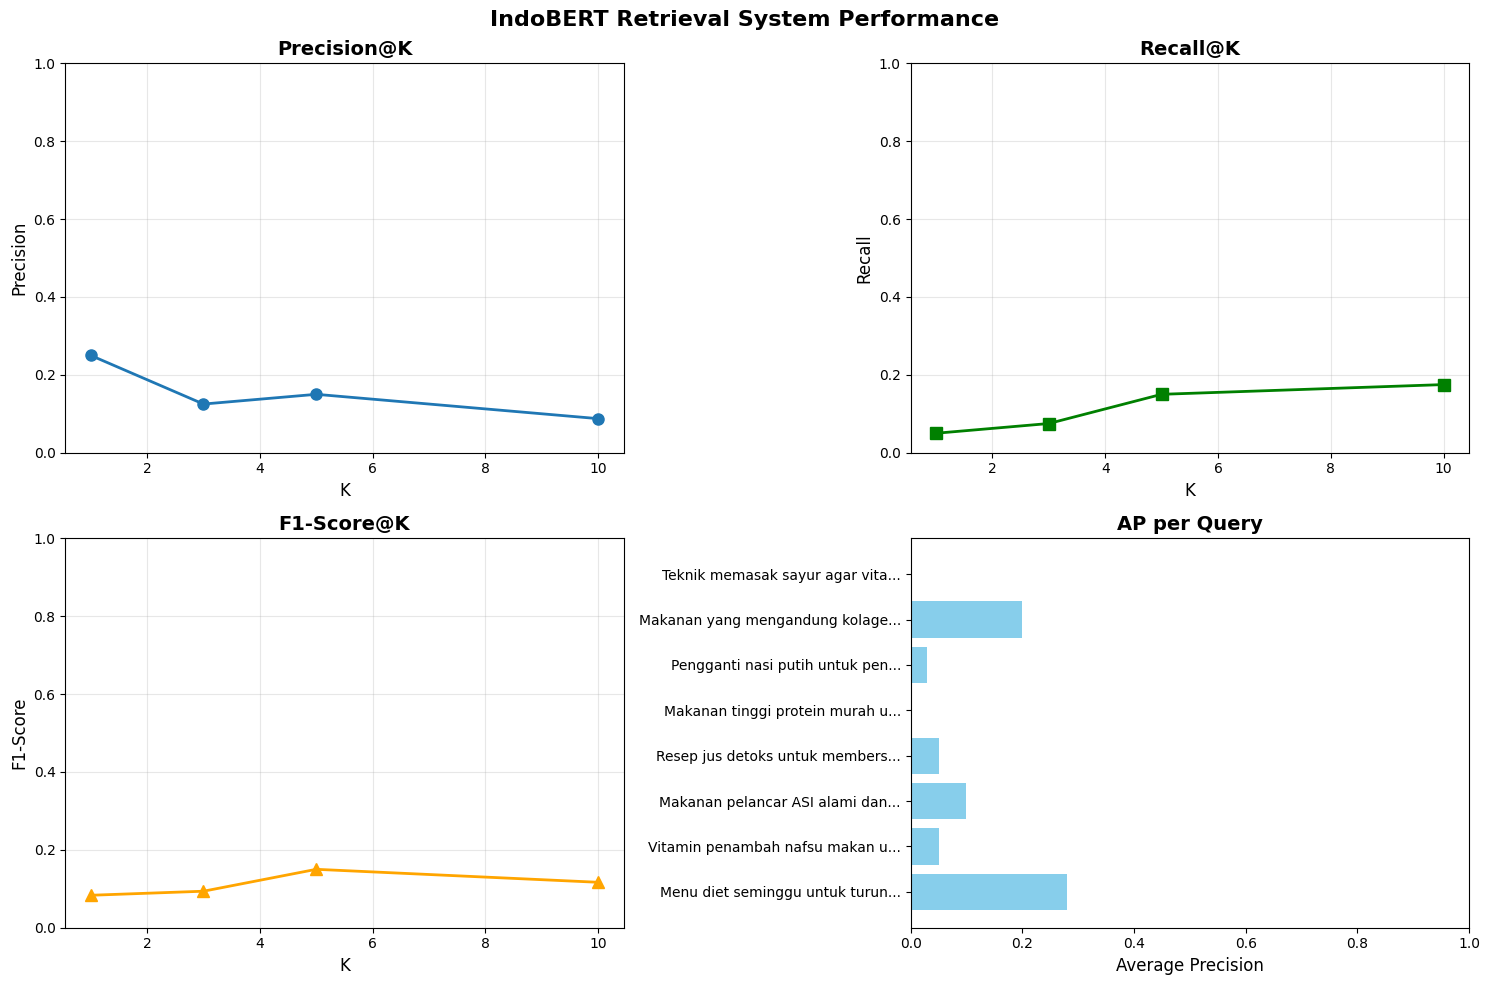

In [31]:
# ============================================================================
# CELL 13: Visualization
# ============================================================================
print("\n" + "="*80)
print("GENERATING VISUALIZATIONS")
print("="*80)

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('IndoBERT Retrieval System Performance', fontsize=16, fontweight='bold')

# 1. Precision@K
k_values = [1, 3, 5, 10]
precision_values = [bert_eval_results['mean'][f'P@{k}'] for k in k_values]
axes[0, 0].plot(k_values, precision_values, marker='o', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('K', fontsize=12)
axes[0, 0].set_ylabel('Precision', fontsize=12)
axes[0, 0].set_title('Precision@K', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_ylim([0, 1])

# 2. Recall@K
recall_values = [bert_eval_results['mean'][f'R@{k}'] for k in k_values]
axes[0, 1].plot(k_values, recall_values, marker='s', color='green', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('K', fontsize=12)
axes[0, 1].set_ylabel('Recall', fontsize=12)
axes[0, 1].set_title('Recall@K', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_ylim([0, 1])

# 3. F1@K
f1_values = [bert_eval_results['mean'][f'F1@{k}'] for k in k_values]
axes[1, 0].plot(k_values, f1_values, marker='^', color='orange', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('K', fontsize=12)
axes[1, 0].set_ylabel('F1-Score', fontsize=12)
axes[1, 0].set_title('F1-Score@K', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_ylim([0, 1])

# 4. Average Precision per Query
queries_short = [q['query'][:30] + '...' for q in bert_eval_results['queries']]
ap_values = [q['AP'] for q in bert_eval_results['queries']]
axes[1, 1].barh(queries_short, ap_values, color='skyblue')
axes[1, 1].set_xlabel('Average Precision', fontsize=12)
axes[1, 1].set_title('AP per Query', fontsize=14, fontweight='bold')
axes[1, 1].set_xlim([0, 1])

plt.tight_layout()
plt.savefig('indobert_evaluation_results.png', dpi=300, bbox_inches='tight')
print("✅ Visualization saved as 'indobert_evaluation_results.png'")
plt.show()



In [16]:
# ============================================================================
# CELL 14: Summary Report
# ============================================================================
print("\n" + "="*80)
print("FINAL SUMMARY REPORT")
print("="*80)

print(f"""
📊 OVERALL PERFORMANCE METRICS (IndoBERT)
{'='*60}
Precision@1  : {bert_eval_results['mean']['P@1']:.2%}
Precision@5  : {bert_eval_results['mean']['P@5']:.2%}
Precision@10 : {bert_eval_results['mean']['P@10']:.2%}

Recall@1     : {bert_eval_results['mean']['R@1']:.2%}
Recall@5     : {bert_eval_results['mean']['R@5']:.2%}
Recall@10    : {bert_eval_results['mean']['R@10']:.2%}

F1-Score@5   : {bert_eval_results['mean']['F1@5']:.2%}
F1-Score@10  : {bert_eval_results['mean']['F1@10']:.2%}

MAP (Mean Average Precision): {bert_eval_results['mean']['MAP']:.2%}
{'='*60}

📈 BEST PERFORMING QUERIES:
""")

# Sort queries by AP
sorted_queries = sorted(bert_eval_results['queries'], key=lambda x: x['AP'], reverse=True)
for i, q in enumerate(sorted_queries[:3], 1):
    print(f"{i}. {q['query']}")
    print(f"   AP: {q['AP']:.2%}, P@5: {q['P@5']:.2%}, R@5: {q['R@5']:.2%}\n")

print(f"""
📉 WORST PERFORMING QUERIES:
""")

for i, q in enumerate(sorted_queries[-3:], 1):
    print(f"{i}. {q['query']}")
    print(f"   AP: {q['AP']:.2%}, P@5: {q['P@5']:.2%}, R@5: {q['R@5']:.2%}\n")

print("="*80)
print("✅ Evaluation complete!")
print("="*80)


FINAL SUMMARY REPORT

📊 OVERALL PERFORMANCE METRICS (IndoBERT)
Precision@1  : 25.00%
Precision@5  : 20.00%
Precision@10 : 12.50%

Recall@1     : 5.00%
Recall@5     : 20.00%
Recall@10    : 25.00%

F1-Score@5   : 20.00%
F1-Score@10  : 16.67%

MAP (Mean Average Precision): 13.75%

📈 BEST PERFORMING QUERIES:

1. Apakah cold pressed juice bagus untuk detoks?
   AP: 40.00%, P@5: 40.00%, R@5: 40.00%

2. Resep makanan untuk anak gemuk dan obesitas
   AP: 6.67%, P@5: 20.00%, R@5: 20.00%

3. Cara memasak agar nutrisi tidak hilang
   AP: 5.00%, P@5: 20.00%, R@5: 20.00%


📉 WORST PERFORMING QUERIES:

1. Resep makanan untuk anak gemuk dan obesitas
   AP: 6.67%, P@5: 20.00%, R@5: 20.00%

2. Cara memasak agar nutrisi tidak hilang
   AP: 5.00%, P@5: 20.00%, R@5: 20.00%

3. Bagaimana cara menurunkan berat badan dengan sehat?
   AP: 3.33%, P@5: 0.00%, R@5: 0.00%

✅ Evaluation complete!
